# 1. Image Classification Task

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Dataset

In [45]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = Dataset.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = Dataset.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


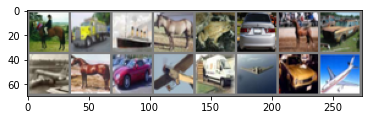

horse truck  ship horse  frog   car horse   car plane horse   car plane truck plane   car plane


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = (img / 2 + 0.5).numpy()     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [51]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (input_channels, output_channels, kernel size)
        self.pool = nn.MaxPool2d(2, 2) #(kernel size : 2 x 2)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120) #(input_dim, output_dim)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Network()

In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [53]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 500 == 499:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

[1,   500] loss: 2.299
[1,  1000] loss: 2.277
[1,  1500] loss: 2.115
[1,  2000] loss: 1.951
[1,  2500] loss: 1.848
[1,  3000] loss: 1.728
[2,   500] loss: 1.642
[2,  1000] loss: 1.586
[2,  1500] loss: 1.553
[2,  2000] loss: 1.500
[2,  2500] loss: 1.474
[2,  3000] loss: 1.435


In [54]:
PATH = './cifar_test.pth'
torch.save(net.state_dict(), PATH)

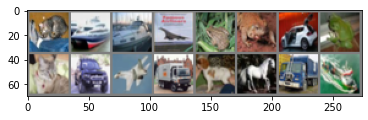

GroundTruth:    cat  ship  ship plane


In [55]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [56]:
net = Network()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [57]:
outputs = net(images)

In [58]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird   car  ship  ship


In [59]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


# 2. Nearest Neighbor Classifier

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

np.random.seed(42)

In [64]:
train_df = pd.read_csv('Desktop/MNIST/mnist_train.csv')
test_df = pd.read_csv('Desktop/MNIST/mnist_test.csv')

In [65]:
x_train = train_df.drop(labels=['label'], axis=1)
y_train = train_df['label']

x_test = test_df.drop(labels=['label'], axis=1)
y_test = test_df['label']

# 데이터 정규화
x_train = x_train / 255.0
x_test = x_test / 255.0

# n 차원 행렬로 변환
x_train = x_train.values
x_test = x_test.values

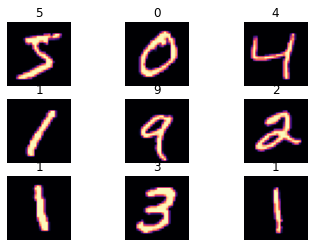

In [76]:
plt.figure
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='magma')
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [71]:
KNN_classifier = KNeighborsClassifier()
KNN_classifier.fit(x_train, y_train)

KNeighborsClassifier()

In [73]:
pred = KNN_classifier.predict(x_test)

acc = accuracy_score(y_test, pred)
acc

0.9688

In [78]:
al = []

for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    acc = accuracy_score(y_test, pred)
    al.append(acc)

/Users/hyunjae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hyunjae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hyunjae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/hyunjae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/hyunjae/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/hyunjae/opt/anaconda3/lib/python3.8/site-packages/ma

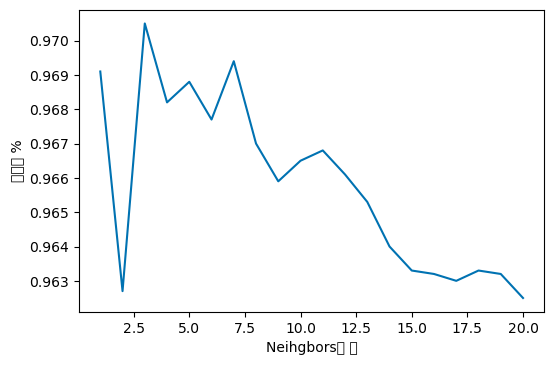

In [79]:
num_k = np.arange(1, 21)
plt.figure(dpi=100)
plt.style.use('seaborn-colorblind')
plt.plot(num_k, al)
plt.xlabel('Neihgbors의 수')
plt.ylabel('정확도 %')
plt.savefig('acc_plot.png')